# Section 4.2.4. Normalized Flow Model (RealNVP)

- The code follows the implementation of Brian Keng. To check the original text and implementation, follow [this link](https://bjlkeng.io/posts/normalizing-flows-with-real-nvp/).

## 1. Training Stage

In [1]:
import math
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

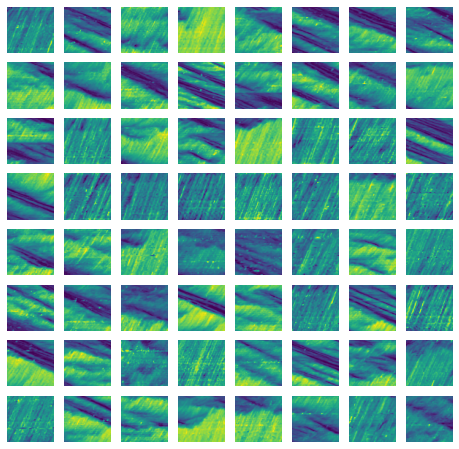

In [2]:
dataset = torch.load('dataset/i24_normalized.pt')

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(dataset[torch.randint(dataset.shape[0], (1,))][0][0], origin="lower" )
        ax[i, j].axis("off")
        
# Create data loaders
data_loader = DataLoader(dataset, batch_size=250, shuffle=True)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super().__init__()
        
        self.conv1 = nn.utils.weight_norm(nn.Conv2d(inplanes, planes, 3, padding=1, bias=False))
        self.bn1 = nn.InstanceNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.utils.weight_norm(nn.Conv2d(planes, planes, 3, padding=1, bias=False))
        self.bn2 = nn.InstanceNorm2d(planes)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class BatchNorm2d(nn.modules.batchnorm._NormBase):
    def __init__(self, num_features, eps=1e-5, momentum=0.005):
        super(BatchNorm2d, self).__init__(num_features, eps, momentum)

    def forward(self, input, validation=False):
        if self.training:
            unbiased_var, tmean = torch.var_mean(input, [0, 2, 3], unbiased=True)
            mean = torch.mean(input, [0, 2, 3]) # along channel axis
            unbiased_var = torch.var(input, [0, 2, 3], unbiased=True) # along channel axis
            running_mean = (1.0 - self.momentum) * self.running_mean.detach() + self.momentum * mean
            running_var = (1.0 - self.momentum) * self.running_var.detach() + self.momentum * unbiased_var
            
            current_mean = running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            denom = (current_var + self.eps)
            y = (input - current_mean) / denom.sqrt()
            
            self.running_mean = running_mean
            self.running_var = running_var
            
            return y, -0.5 * torch.log(denom)
        else:
            current_mean = self.running_mean.view([1, self.num_features, 1, 1]).expand_as(input)
            current_var = self.running_var.view([1, self.num_features, 1, 1]).expand_as(input)
            
            if validation:
                denom = (current_var + self.eps)
                y = (input - current_mean) / denom.sqrt()
            else:
                # Reverse operation for testing
                denom = (current_var + self.eps)
                y = input * denom.sqrt() + current_mean
                
            return y, -0.5 * torch.log(denom)

def bottleneck_backbone(in_planes, planes):
    return nn.Sequential(
        nn.utils.weight_norm(nn.Conv2d(in_planes, planes, 3, padding=1, bias=False)),
        nn.InstanceNorm2d(planes),
        BasicBlock(planes, planes),
        nn.utils.weight_norm(nn.Conv2d(planes, in_planes, 3, padding=1, bias=False)),
        nn.InstanceNorm2d(planes),
    )

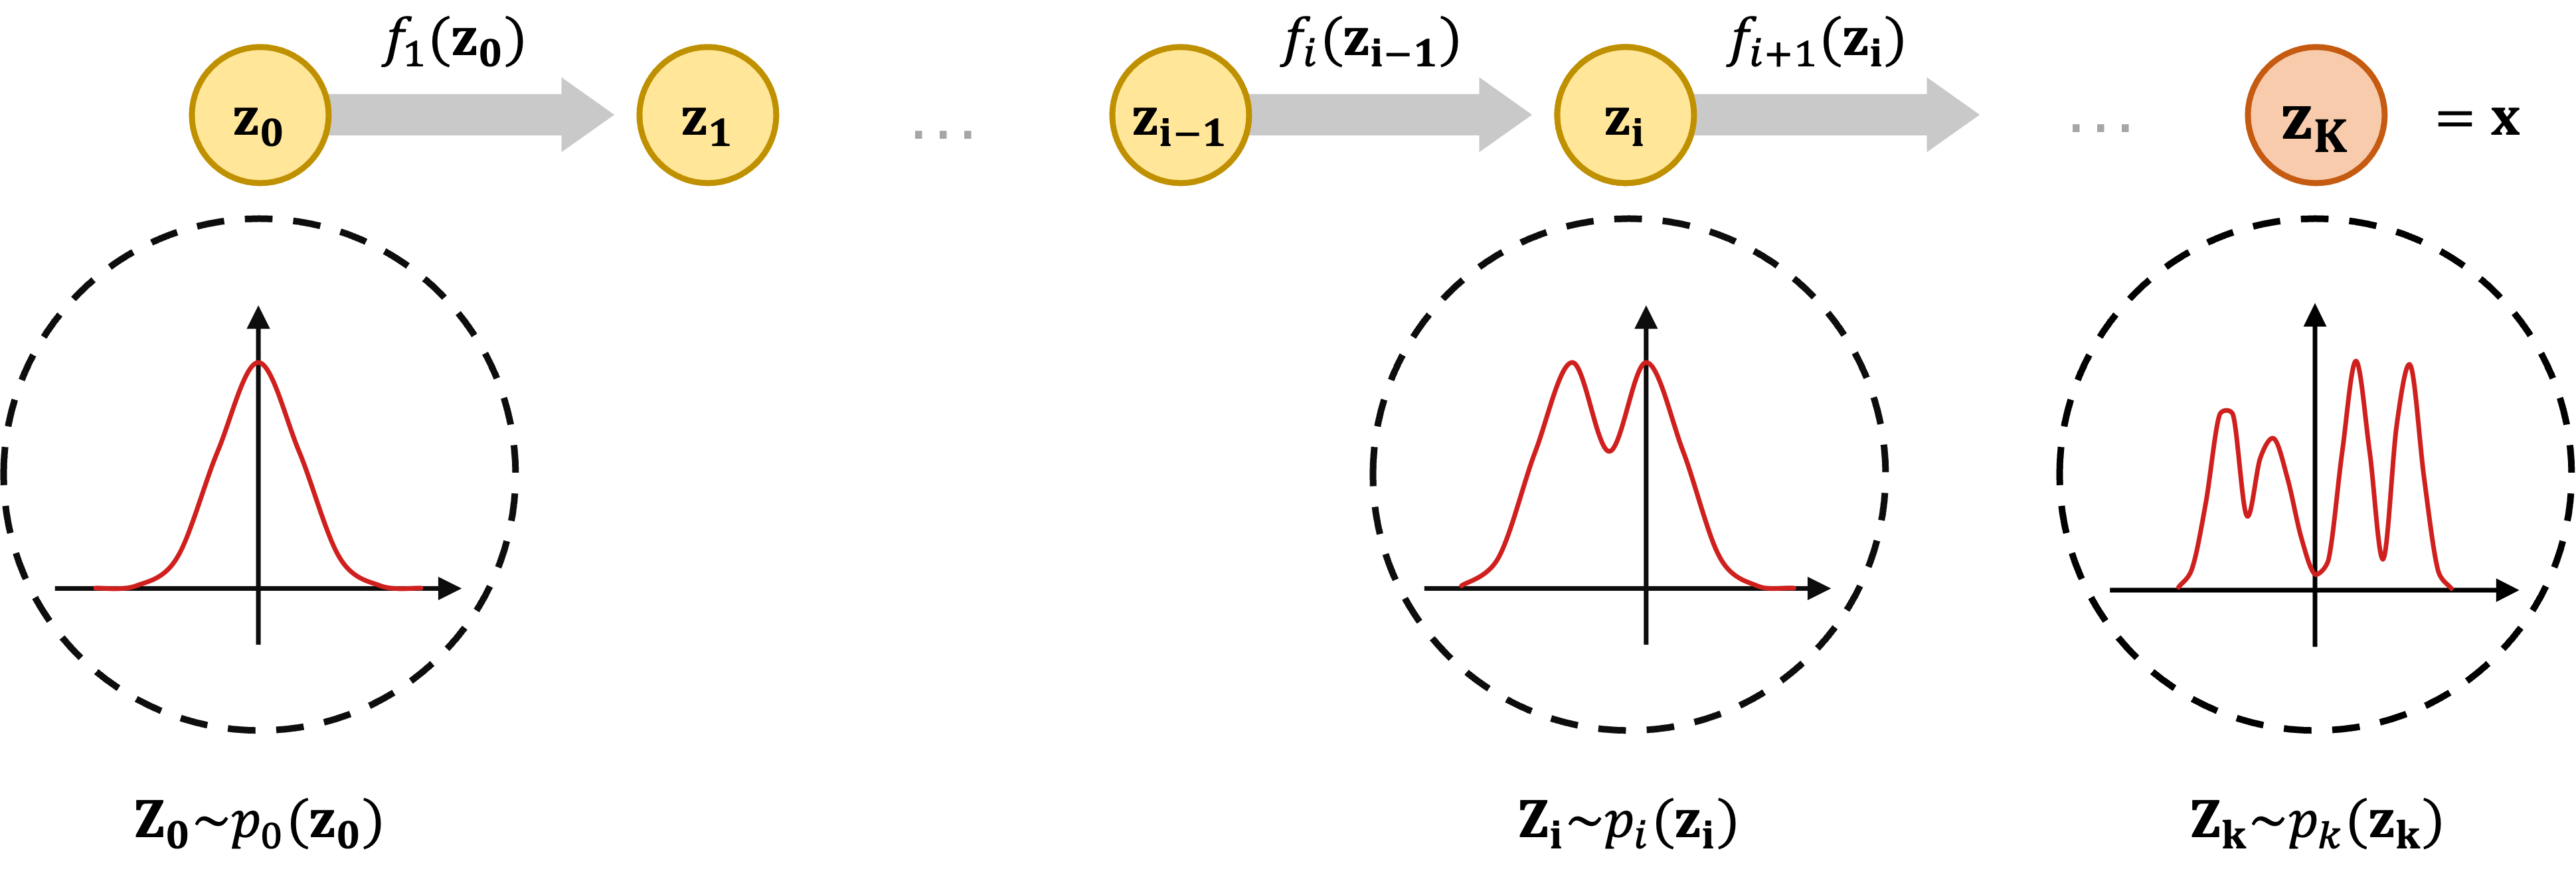

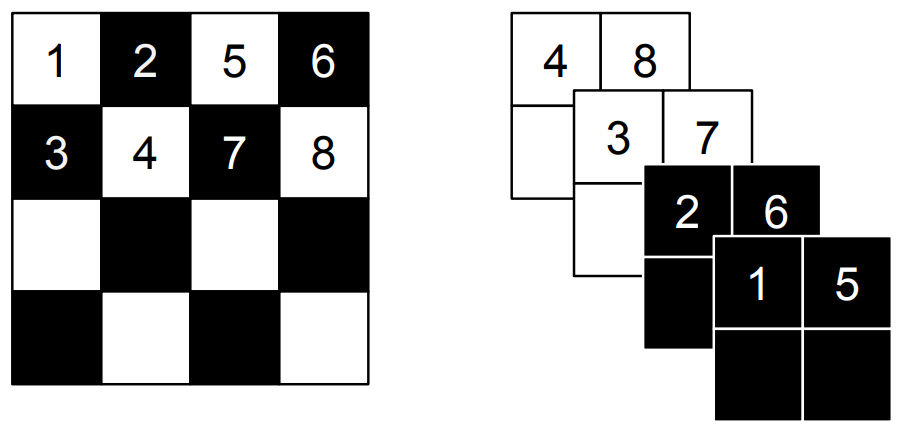
- Checkerboard mask(left) and Channel mask(right) (Figure from original RealNVP paper)

In [4]:
check_mask = {}
check_mask_device = {}

def checkerboard_mask(shape, to_device=True):
    global check_mask, check_mask_device
    if shape not in check_mask:
        check_mask[shape] = 1 - np.indices(shape).sum(axis=0) % 2
        check_mask[shape] = torch.Tensor(check_mask[shape])
        
    if to_device and shape not in check_mask_device:
        check_mask_device[shape] = check_mask[shape].to(device)
        
    return check_mask_device[shape] if to_device else check_mask[shape]

chan_mask = {}
chan_mask_device = {}

def channel_mask(shape, to_device=True):
    assert len(shape) == 3, shape
    assert shape[0] % 2 == 0, shape
    global chan_mask, chan_mask_device
    if shape not in chan_mask:
        chan_mask[shape] = torch.cat([torch.zeros((shape[0] // 2, shape[1], shape[2])),
                                      torch.ones((shape[0] // 2, shape[1], shape[2])),],
                                      dim=0)
        assert chan_mask[shape].shape == shape, (chan_mask[shape].shape, shape)
        
    if to_device and shape not in chan_mask_device:
        chan_mask_device[shape] = chan_mask[shape].to(device)
        
    return chan_mask_device[shape] if to_device else chan_mask[shape]

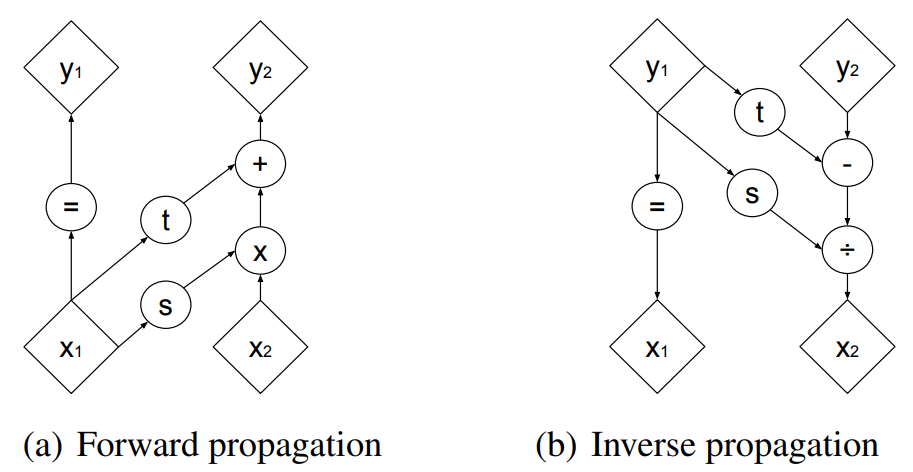

Scale and Translation transformation. Mathematically, it is procceded as below.

\begin{align}
& \mathbf{y}_{1:d} = \mathbf{x}_{1:d}, \\
& \mathbf{y}_{d+1:D} = \mathbf{x}_{d+1:D} \odot \exp{\left( s(\mathbf{x}_{1:d} ) \right)} + t(\mathbf{x}_{1:d} ), \\    
\end{align}

\begin{align}
& \mathbf{x}_{1:d} = \mathbf{y}_{1:d}, \\
& \mathbf{x}_{d+1:D} = \left( \mathbf{y}_{d+1:D} - t\left( \mathbf{y}_{1:d}  \right)\right) \odot \exp{\left( -s\left( \mathbf{y}_{1:d} \right) \right)}\\
\end{align}

In [5]:
class NormalizingFlow(nn.Module):
    EPSILON = 1e-5
    
    def __init__(self, num_coupling=6, num_final_coupling=4, planes=64):
        super(NormalizingFlow, self).__init__()
        self.num_coupling = num_coupling
        self.num_final_coupling = num_final_coupling
        self.shape = (1, 64, 64)
        
        self.planes = planes
        self.s = nn.ModuleList()
        self.t = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        # Learnable scalar scaling parameters for outputs of S and T
        self.s_scale = nn.ParameterList()
        self.t_scale = nn.ParameterList()
        self.t_bias = nn.ParameterList()
        self.shapes = []
      
        shape = self.shape
        for i in range(num_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(BatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
            if i % 6 == 2:
                shape = (4 * shape[0], shape[1] // 2, shape[2] // 2)
                
            if i % 6 == 5:
                # Factoring out half the channels
                shape = (shape[0] // 2, shape[1], shape[2])
                planes = 2 * planes
       
        # Final coupling layers checkerboard
        for i in range(num_final_coupling):
            self.s.append(bottleneck_backbone(shape[0], planes))
            self.t.append(bottleneck_backbone(shape[0], planes))
            
            self.s_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_scale.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            self.t_bias.append(torch.nn.Parameter(torch.zeros(shape), requires_grad=True))
            
            self.norms.append(BatchNorm2d(shape[0]))
            
            self.shapes.append(shape)
           
        self.validation = False
    
    def validate(self):
        self.eval()
        self.validation = True
        
    def train(self, mode=True):
        nn.Module.train(self, mode)
        self.validation = False

    def forward(self, x):
        if self.training or self.validation:
            s_vals = []
            norm_vals = []
            y_vals = []
            
            for i in range(self.num_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
               
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                    
                if i % 6 == 2:
                    y = torch.nn.functional.pixel_unshuffle(y, 2)
                    
                if i % 6 == 5:
                    factor_channels = y.shape[1] // 2
                    y_vals.append(torch.flatten(y[:, factor_channels:, :, :], 1))
                    y = y[:, :factor_channels, :, :]
                    
                x = y
                
            # Final checkboard coupling
            for i in range(self.num_coupling, self.num_coupling + self.num_final_coupling):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
               
                t = (self.t_scale[i]) * self.t[i](mask * x) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * x))
                y = mask * x + (1 - mask) * (x * torch.exp(s) + t)
                s_vals.append(torch.flatten((1 - mask) * s))
                
                if self.norms[i] is not None:
                    y, norm_loss = self.norms[i](y, validation=self.validation)
                    norm_vals.append(norm_loss)
                
                x = y

            y_vals.append(torch.flatten(y, 1))
            
            # Return outputs and vars needed for determinant
            return (torch.flatten(torch.cat(y_vals, 1), 1),
                    torch.cat(s_vals), 
                    torch.cat([torch.flatten(v) for v in norm_vals]) if len(norm_vals) > 0 else torch.zeros(1),
                    torch.cat([torch.flatten(s) for s in self.s_scale]))
        else:
            y = x
            y_remaining = y
           
            layer_vars = np.prod(self.shapes[-1])
            y = torch.reshape(y_remaining[:, -layer_vars:], (-1,) + self.shapes[-1])
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Reversed final checkboard coupling
            for i in reversed(range(self.num_coupling, self.num_coupling + self.num_final_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
                
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
              
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                y = x           
          
            layer_vars = np.prod(shape)
            y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
            y_remaining = y_remaining[:, :-layer_vars]
            
            # Multi-scale coupling layers
            for i in reversed(range(self.num_coupling)):
                shape = self.shapes[i]
                mask = checkerboard_mask(shape) if i % 6 < 3 else channel_mask(shape)
                mask = mask if i % 2 == 0 else (1 - mask)
              
                if self.norms[i] is not None:
                    y, _ = self.norms[i](y)
                    
                t = (self.t_scale[i]) * self.t[i](mask * y) + (self.t_bias[i])
                s = (self.s_scale[i]) * torch.tanh(self.s[i](mask * y))
                x = mask * y + (1 - mask) * ((y - t) * torch.exp(-s))
               
                if i % 6 == 3:
                    x = torch.nn.functional.pixel_shuffle(x, 2)
                    
                y = x
                
                if i > 0 and i % 6 == 0:
                    layer_vars = np.prod(shape)
                    y = torch.cat((y, torch.reshape(y_remaining[:, -layer_vars:], (-1,) + shape)), 1)
                    y_remaining = y_remaining[:, :-layer_vars]
            
            assert np.prod(y_remaining.shape) == 0
            
            return x

Apply transform to deal with boundary effects

\begin{align}
h(x) = logit(\frac{0.9x}{256} + 0.05)
\end{align}

\begin{align}
\frac{dh(x)}{dx} = \frac{0.9}{256}\big(\frac{1}{\frac{0.9x}{256} + 0.05} + \frac{1}{1 - (\frac{0.9x}{256} + 0.05)}\big)
\end{align}

In [6]:
def pre_process(x):
    x = x * 255.
    x = x + torch.rand(x.shape)

    x = torch.logit(0.05 + 0.90 * x / 256)
    return x

def post_process(x):
    return torch.clip(torch.floor(256 / 0.90 * (torch.sigmoid(x) - 0.05)), min=0, max=255) / 255
    
def log_preprocessing_grad(y):
    x = 256 / 0.90 * (torch.sigmoid(y) - 0.05)
    arg = 0.9 * x / 256 + 0.05
    return torch.log(1 / arg + 1 / (1 - arg)) + np.log(0.9 / 256)

Loss function with logpx and det is determined as below.

\begin{split}
    \log \left(p_X(x)\right)+ \text{Reg. Loss} &= \log \left(p_Z(f(x))\right)+\log \left(\left|\operatorname{det}\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right) + \text{Reg.(Batch Norm. and Scale Params.)} \\
    &=\frac{1}{2}\log(2\pi) + \frac{(f_\theta(x))^2}{2}- \sum_j s(x_{1:d})_j +  \frac{1}{2}\sum_i \log(\tilde{\sigma}_i^2 + \epsilon) + \sum_k \| scale_{k} \|^2\\
    &\rightarrow(f_\theta(x))^2- \sum_j s(x_{1:d})_j + \sum_i \log(\tilde{\sigma}_i^2 + \epsilon) + \sum_k \| scale_{k} \|^2
\end{split} 

The coefficient is determined based in empirical rule.

In [7]:
learning_rate = 0.0007

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NormalizingFlow(num_coupling=18, num_final_coupling=4, planes=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.995)

def loss_fn(y, s, norms, scale, batch_size):
    # -log(zero-mean gaussian) + log determinant
    # -log p_x = log(pz(f(x))) + log(det(\partial f/\partial x))
    # -log p_x = 0.5 * y**2 + s1 + s2 + ... + batch_norm_scalers + l2_regularizers(scale)
    PI = torch.tensor(np.pi)
    logpx = -100 * torch.sum(0.5 * math.log(2 * PI) + 0.5 * y**2) / 1e+6
    det = 10 * torch.sum(s) / 2e+4
    norms = 500 * torch.sum(norms) /  2e+6
    reg = 100 * torch.sum(scale ** 2) *2.5
    loss = -(logpx + det + norms) + reg
    return torch.div(loss, batch_size), (-logpx, -det, -norms, reg)

In [8]:
print('Change of dimension of the input of the RealNVP')
summary(model, (1, 64, 64))

Change of dimension of the input of the RealNVP
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             576
    InstanceNorm2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,864
    InstanceNorm2d-4           [-1, 64, 64, 64]               0
              ReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,864
    InstanceNorm2d-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
        BasicBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10            [-1, 1, 64, 64]             576
   InstanceNorm2d-11            [-1, 1, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]             576
   InstanceNorm2d-13           [-1, 64, 64, 64]        

In [ ]:
# Training loop
num_epochs = 20
saved=False
for epoch in range(num_epochs):
    model.train()
    logpx_loss_sum = 0
    det_loss_sum = 0
    norms_loss_sum = 0
    reg_loss_sum = 0
    
    for idx, data in enumerate(data_loader):
        if saved: break
        optimizer.zero_grad()
        data = pre_process(data)
        data = data.to(device)
        batch_size = data.size(0)
        
        y, s, norms, scale = model(data)
        loss, comp = loss_fn(y, s, norms, scale, batch_size)
        
        logpx_loss = comp[0] * 1e+4
        det_loss = comp[1] * 2e+3
        norms_loss = comp[2] * 4e+3
        reg_loss = comp[3] / 250
    
        loss -= torch.sum(log_preprocessing_grad(data)) / batch_size
        loss.backward()
        optimizer.step()
        
        loss = loss.item()
        if (norms_loss < -620 * 4e+3) & (logpx_loss < 145 * 1e+4):
            # For RealNVP, save the model selectively
            print(f"Stopping training early at epoch {epoch + 1}")
            torch.save(model.state_dict(), 'models/RealNVP_model.pth')
            print("RealNVP model saved.")
            saved=True
            break
        
        logpx_loss_sum += logpx_loss*batch_size
        det_loss_sum += det_loss*batch_size
        norms_loss_sum += norms_loss*batch_size
        reg_loss_sum += reg_loss*batch_size
    
    logpx_loss_sum = logpx_loss_sum/dataset.shape[0]
    det_loss_sum = det_loss_sum/dataset.shape[0]
    norms_loss_sum = norms_loss_sum/dataset.shape[0]
    reg_loss_sum = reg_loss_sum/dataset.shape[0]

    print(f'Epoch [{epoch+1:02}/{num_epochs}]  logpx_loss: {logpx_loss_sum:>8.1f}  det_loss: {det_loss_sum:>5.1f}  norms_loss: {norms_loss_sum:>8.1f}  reg_loss: {reg_loss_sum:>8.6f}')

## 2. Testing Stage

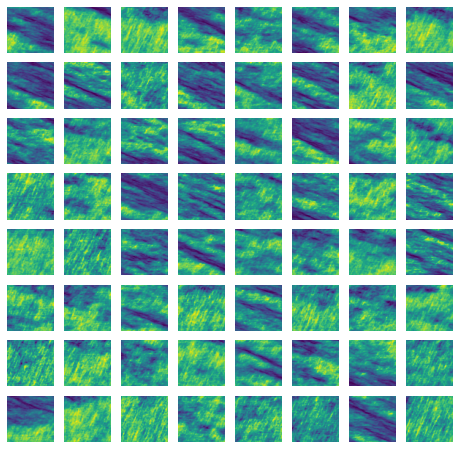

In [37]:
# Highly recommend to use GPU
device = "cpu"

model = NormalizingFlow(num_coupling=18, num_final_coupling=4, planes=64).to(device)
model.load_state_dict(torch.load('models/RealNVP_model.pth', map_location="cpu"))
model.eval()

with torch.no_grad():
    X = torch.Tensor(torch.normal(torch.zeros(64, 64 * 64 * 1),
                                  torch.ones(64, 64 * 64 * 1))).to(device)
    Y = model(X)
    sample = post_process(Y).cpu()

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][0,:,:], origin="lower")
        ax[i, j].axis("off")
        
plt.savefig("img/RealNVP_result.png", dpi=500)
plt.show()